In [1]:
import sys
from os import path
sys.path.append(path.join(path.dirname(path.abspath("__file__")), '..'))
# sys.path.append(path.join(path.dirname(path.abspath("__file__")), '..'))
import aestimo as solver
import config as ac
ac.messagesoff = True # turn off logging in order to keep notebook from being flooded with messages.
import database as adatabase
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import copy
from pprint import pprint
     

WARNING aestimo logs automatically to aestimo.log in the example's directory.
WARNING psi_at_inf_cython module not found


In [2]:

class Structure(object): pass
s0 = Structure() # this will be our datastructure

# TEMPERATURE
s0.T = 11.0 #Kelvin

# COMPUTATIONAL SCHEME
# 0: Schrodinger
# 1: Schrodinger + nonparabolicity
# 2: Schrodinger-Poisson
# 3: Schrodinger-Poisson with nonparabolicity
# 4: Schrodinger-Exchange interaction
# 5: Schrodinger-Poisson + Exchange interaction
# 6: Schrodinger-Poisson + Exchange interaction with nonparabolicity
s0.computation_scheme = 1

# Non-parabolic effective mass function
# 0: no energy dependence
# 1: Nelson's effective 2-band model
# 2: k.p model from Vurgaftman's 2001 paper
s0.meff_method = 0

# Non-parabolic Dispersion Calculations for Fermi-Dirac
s0.fermi_np_scheme = True #needed only for aestimo_numpy2.py

# QUANTUM
# Total subband number to be calculated for electrons
s0.subnumber_e = 2

# APPLIED ELECTRIC FIELD
s0.Fapplied = 0.00 # (V/m)

# GRID
# For 1D, z-axis is choosen
s0.gridfactor = 0.1 #nm
s0.maxgridpoints = 200000 #for controlling the size

# REGIONS
# Region input is a two-dimensional list input.
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
well_l = 5.0
# s0.material =[
#             [ 20.0, 'InAlAs', 0.52, 0.0, 'n'],
#             [ well_l, 'InGaAs', 0.53, 2e16, 'n'],
#             [ 20.0, 'InAlAs', 0.52, 0.0, 'n'],
#             ]

s0.material =[
            [ 20.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ well_l, 'GaAs', 0.0, 2e16, 'n'],
            [ 20.0, 'AlGaAs', 0.3, 0.0, 'n'],
            ]

structure0 = s0

In [3]:
q = 1.602176e-19 #C
meV2J=1e-3*q #meV to Joules

In [4]:
def plot_QW_view(result, title=None, wavefunction_scalefactor=None, chemical_potential=False, 
                 title_fontsize=16, axis_fontsize=14, tick_fontsize=12, legend_fontsize=12,legend_loc = "best",figsize=(8, 6)):
    """
    Plots the quantum well view with wavefunctions.

    Parameters:
    - result: The simulation result containing wavefunctions and energy levels.
    - title: Title of the plot.
    - wavefunction_scalefactor: Optional. Scaling factor for the wavefunctions. Defaults to ac.wavefunction_scalefactor.

    - chemical_potential: Optional. Whether to plot the chemical potential. Defaults to False.

    - title_fontsize: Optional. Font size for the plot title. Defaults to 16.
    - axis_fontsize: Optional. Font size for the axis labels. Defaults to 14.
    - tick_fontsize: Optional. Font size for the axis numbers. Defaults to 12.
    - legend_fontsize: Optional. Font size for the legend. Defaults to 12.
    """
    fig2 = plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title, fontsize=title_fontsize)
    ax = plt.subplot(1, 1, 1)
    
    # Rescale CBM to 0 eV
    CBM = min(result.fitot)  # Conduction Band Minimum
    potential_rescaled = (result.fitot - CBM) / meV2J  # Rescale potential to 0 eV
    energy_levels_rescaled = [(level - CBM / meV2J) for level in result.E_state]  # Rescale energy levels
    
    # Plot rescaled potential
    ax.plot(result.xaxis * 1e9, potential_rescaled, "k", label="Potential")
    
    # Use the provided scaling factor or default to ac.wavefunction_scalefactor
    scaling_factor = wavefunction_scalefactor if wavefunction_scalefactor is not None else ac.wavefunction_scalefactor
    
    # Generate a colormap for the wavefunctions
    colormap = plt.get_cmap('plasma')
    
    # Plot rescaled energy levels and wavefunctions
    for i, (level, state) in enumerate(zip(energy_levels_rescaled, result.wfe)):
        wfsq = state**2
        color = colormap(i / len(result.wfe))  # Get a shade of blue
        ax.axhline(level, 0.1, 0.9, color="b", ls="--", label="$E_{subband}$" if i == 0 else None)  # Label only the first line
        ax.plot(result.xaxis * 1e9, wfsq * scaling_factor + level, color=color)
    
    # Plot chemical potential if enabled
    if chemical_potential:
        chemical_potential_rescaled = (result.E_F - CBM / meV2J)  # Rescale chemical potential
        ax.axhline(chemical_potential_rescaled, 0.1, 0.9, color="r", ls="--", label="Chemical potential")
    
    # Set axis labels and font sizes
    ax.set_xlabel("z (growth direction) [nm]", fontsize=axis_fontsize)
    
    ax.set_ylabel("Energy-GaAs CBM [meV]", fontsize=axis_fontsize)
    
    # Adjust tick font sizes
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    
    # Add legend with custom font size
    ax.legend(loc=legend_loc,fontsize=legend_fontsize)
    
    ax.grid(True)
    return fig2

INFO Total layer number: 3
INFO Total number of materials in database: 26
INFO calculation time  0.090071 s


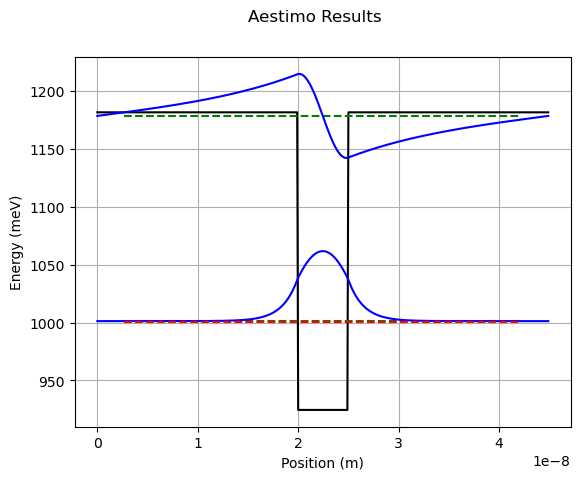

INFO Simulation is finished.


In [5]:
s1 = copy.copy(s0) #simpler than redefining everything and changes to s0 should propagate to s1
# barrier_layer = 2 # defines which layer will be adjusted later
# # s1.subnumber_e = 4
# # x_conc = 0.33
# # surrounding_barrier = 5.0
# # s1.material = [
# #             [ surrounding_barrier, 'AlGaAs', x_conc, 0.0, 'n'],
# #             [ 13.0, 'GaAs', 0, 2e16, 'n'],
# #             [1.5, 'AlGaAs', x_conc, 0.0, 'n'], #barrier layer
# #             [ 4.8, 'GaAs', 0, 2e16, 'n'],            
# #             [ surrounding_barrier, 'AlGaAs', x_conc, 0.0, 'n'],
# #             ]

# x_conc = 0.448
# doping = 2e16 #cm^-3

# singleperiod_lengths = np.array([8.0, 60.0, 6.5, 68, 6.5, 78.0, 32.0, 39.0, 25.0,42.0,20.0,46.0,18.0,50.0,15.0,53.0,12.0,55.0])*0.1  # Lengths of each well (nm)

# # top_epilayers = np.array([33.9,62.2,28.3,79.1,17])*0.1  # Lengths of each well (nm)
# # Automatically generate the material list
# # epilayer_lengths = np.concatenate((singleperiod_lengths, singleperiod_lengths))

# # singleperiod_lengths = np.array([20,20,10,10,5,5,2,2,30])  # Lengths of each well (nm)
# # Initialise the material list with a GaAs layer at the beginning
# # s1.material = [[50, 'GaAs', 0, doping, 'n']]  # Add the initial GaAs layer
# s1.material = []  # Start with an empty material list
# for i, length in enumerate(singleperiod_lengths):
#     if i % 2 == 0:  # Even indices are AlGaAs (barrier layers)
#         s1.material.append([length, 'AlGaAs', x_conc, 0.0, 'n'])
#     else:  # Odd indices are GaAs (well layers)
#         s1.material.append([length, 'GaAs', 0, doping, 'n'])

# s1.subnumber_e = 15# There will be double the number of energy states now.



# Initialise structure class
model1 = solver.StructureFrom(s1,adatabase) # structure could also be a dictionary.

#calculate QW states
result1 = solver.Poisson_Schrodinger(model1)

#solver.save_and_plot(result,model)
solver.QWplot(result1,figno=None)
solver.logger.info("Simulation is finished.")

state, Energy
     ,meV
    0 1001.21
    1 1178.52


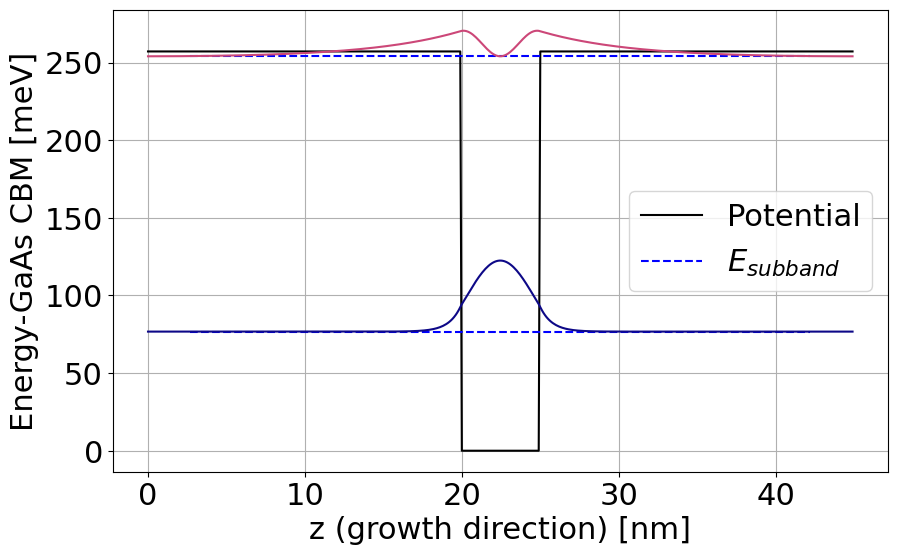

In [6]:
fontsize_base = 22
figtest2 = plot_QW_view(result1,wavefunction_scalefactor=2000,title_fontsize=fontsize_base,axis_fontsize=fontsize_base,tick_fontsize=fontsize_base,legend_fontsize=fontsize_base,legend_loc="center right",figsize=(10,6))

print('state, Energy')
print('     ,meV')
for num,E in zip(range(result1.subnumber_e),result1.E_state):
    print('%5d %7g' %(num,E))